Bishop et al: https://www.nature.com/articles/nphys1154

Qutip reference:

https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/rabi-oscillations.ipynb

https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/ultrastrong-coupling-groundstate.ipynb

http://qutip.org/docs/3.1.0/apidoc/functions.html

Koch 2007: https://arxiv.org/pdf/cond-mat/0703002.pdf

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, stats, integrate
from qutip import *
# Note to self: ^ IS NOT POWER, ** IS POWER

In [3]:
# h = 6.62607004*10**(-34)
hbar = 1 # NECESSARY TO MAKE SOLVER WORK
h = hbar*2*np.pi

# Unit conversions
# MHz = 10.0**6
# GHz = 10.0**9
# kHz = 10.0**3
# mus = 10.0**-6
# ns = 10.0**-9
MHz = 10.0**(-3)
GHz = 1.0 # NECESSARY TO MAKE SOLVER WORK
kHz = 10.0**(-6)
mus = 10.0**3
ns = 1.0

# Transmon constants
EC = 400*MHz*h
# EJ = 41.7*EC # temporary, this will be defined later as bestEJ

# number of cavity states
# Nr = 3
Nr = 5
# number of transmon states
Nj = 5

# cavity/resonator frequency
wr = 2*np.pi*6.92*GHz
# transmon frequency (temporary)
wj = np.asarray([wr]*Nj)
# drive frequency (temporary)
wd = wr

# transmon-resonator coupling strength
g0 = np.pi*347*MHz
gj = g0 * np.asarray([np.sqrt(j+1) for j in range(Nj)])

# cavity dissipation rate
kappa = 2*np.pi*300*kHz
# transmon relaxation rate (2pi/T1)
T1 = 1.7*mus
gamma1 = 2*np.pi/(T1)
# transmon dephasing rate
gammaphi = 0.0
# relative strengths of damping
alphaj = gj/g0

# for the TLS stuff
T1p = 2/(gamma1+kappa)
T2p = 4/(gamma1+2*gammaphi+kappa)

use_rwa = True

a = tensor(destroy(Nr), qeye(Nj)) # cavity op

In [4]:
# Transmon corrected energies from perturbation theory (Koch p. 19)
def getWij(i, j, EC, EJ):
    b = destroy(Nj) # pure SHO operators
    Hsho = np.sqrt(8*EC*EJ)*(b.dag()*b + 1/2)-EJ
    evals, ekets = Hsho.eigenstates()
    ECorrect = [evals[j] - EC/12*(6*j**2 + 6*j + 3) for j in range(Nj)]
    return (ECorrect[j]-ECorrect[i])/hbar

# Transmon states from perturbation theory (Koch p. 19)
def getJKets(EC, EJ):
    b = destroy(Nj) # pure SHO operators
    Hsho = np.sqrt(8*EC*EJ)*(b.dag()*b + 1/2)-EJ
    evals, ekets = Hsho.eigenstates()
#     print(evals/hbar)
    ECorrect = [evals[j] - EC/12*(6*j**2 + 6*j + 3) for j in range(Nj)]
#     print("%.3e" % (ECorrect[0]/hbar))
#     print("alpha/EC: %.2f" % ((ECorrect[2]-ECorrect[1]-(ECorrect[1]-ECorrect[0]))/(hbar*EC)))
    jketsCorrect = np.copy(ekets)
    jkets1 = np.asarray([0*basis(Nj,0)]*Nj, dtype=object)
    for j in range(Nj):
        for i in range(Nj):
            if i == j: continue
            quartic = (b+b.dag())**4
            element = quartic.matrix_element(ekets[i], ekets[j])
            jkets1[j] += (element*ekets[i])/(ECorrect[i]-ECorrect[j])
        jkets1[j] *= -EC/12
    jketsCorrect += jkets1
    
    return jketsCorrect

# getJKets(EC, EJ)

In [5]:
# also known as the nkets
def getPhotonKets():
    a = destroy(Nr)
    H = hbar*wr*a.dag()*a
    # need to include the drive term here??
    evals, ekets = H.eigenstates()
    return ekets

In [6]:
# JC with coherent drive (Bishop p. 1)

def getHjc(xi, wd, jkets, pN):
    Hjc_0 = hbar*wr*a.dag()*a
    for j in range(Nj):
        Hjc_0 += hbar*wj[j]*tensor(qeye(Nr), ket2dm(jkets[j]))
    for j in range(Nj-1):
        temp = a*tensor(qeye(Nr), jkets[j+1]*jkets[j].dag())
        Hjc_0 += hbar*gj[j]*(temp + temp.dag())
    Hjc_0 = pN*Hjc_0
    
    # Break up Hjc into time independent, dependent to put into mesolve
    # (See http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html)
    Hjc_1 = hbar*xi*a.dag()
    Hjc_1 = pN*Hjc_1
    Hjc_2 = hbar*xi*a
    Hjc_2 = pN*Hjc_2
    def Hjc1_time_dep(t, args):
        return np.exp(-1j*wd*t)
    def Hjc2_time_dep(t, args):
        return np.exp(1j*wd*t)
    
    Hjc = [Hjc_0, [Hjc_1, Hjc1_time_dep], [Hjc_2, Hjc2_time_dep]]
    # Hjc = Hjc_0
    # print(Hjc_0)
    return Hjc

# projection operator onto total n+j = N excitations
def projN(N, nkets, jkets):
    pN = 0*tensor(qeye(Nr), qeye(Nj))
    for n in range(Nr):
        for j in range(Nj):
            if n+j > N: continue
#             print(n,j)
            njKet = tensor(nkets[n], jkets[j])
            pN += ket2dm(njKet)
    return pN

# TLS mapping:

(Figure 2 green lines)

In [7]:
def intensityTLS(xi, wd, EC, EJ):
    Omega = np.sqrt(2)*xi
    Delta = getWij(0, 1, EC, EJ)-g0-wd
    numerator = T2p*Omega*np.sqrt((Delta**2*T2p**2 + 1)/2)
    denominator = Delta**2*T2p**2 + T1p*T2p*Omega**2 + 1
    return (numerator/denominator)**2/4 # A^2/A1^2

### Get best EJ

In [18]:
nPoints = 100
xData = np.linspace(6.5*GHz, 7.1*GHz, num = nPoints)
yData = []

# drive strength: expect supersplitting when strength>1
strength = 0.1
xi = (1/np.sqrt(2*T1p*T2p))*strength
# print(xi)


# Find the EJ that gets you closest to the one in the paper
EJtry = np.linspace(41*EC, 42*EC, num = 50)
bestEJ = 0
minDist = 1000*GHz
closestFreq = 0
for EJ in EJtry:
    yData = []
    for fd in xData:
        yData.append(intensityTLS(xi, fd*2*np.pi, EC, EJ))
    peakI = np.max(yData)
    peakFreqLoc = np.where(yData == peakI)[0][0]
    peakFreq = xData[peakFreqLoc]
    if np.abs(peakFreq - 6.734*GHz) < minDist:
        bestEJ = EJ
        closestFreq = peakFreq
        minDist = np.abs(peakFreq - 6.734*GHz)
print(bestEJ/EC)
print(closestFreq/GHz)

41.714285714285715
6.736363636363636


Done with strength=0.8


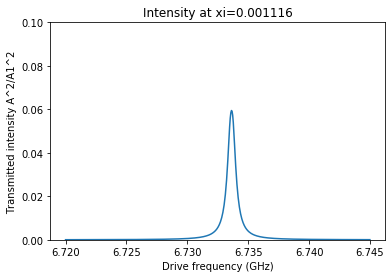

Done with strength=1.7


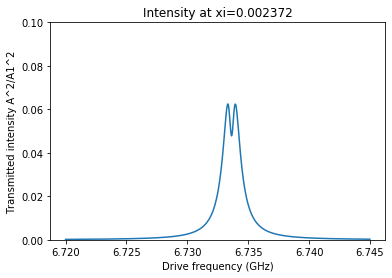

Done with strength=5.0


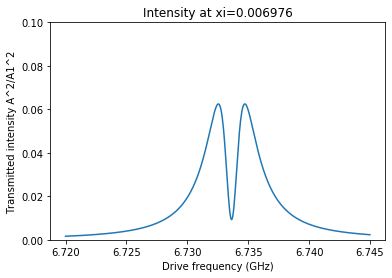

In [ ]:
nPoints = 500
xData = np.linspace(6.72*GHz, 6.745*GHz, num = nPoints)

# drive strength: expect supersplitting when strength>1
for strength in [0.8, 1.7, 5, 20]:
    xi = (1/np.sqrt(2*T1p*T2p))*strength
    fig2TLSYData = []
    for i, fd in enumerate(xData):
#         if i % 100 == 0:
#             print("%d of %d done" % (i, nPoints))
        fig2TLSYData.append(intensityTLS(xi, fd*2*np.pi, EC, bestEJ))
    print("Done with strength=%.1f" % strength)
    
    plt.plot(xData, fig2TLSYData)
    plt.xlabel('Drive frequency (GHz)')
    plt.ylabel('Transmitted intensity A^2/A1^2')
    plt.ylim(0, 0.1)
    plt.title("Intensity at xi=%f" % xi)
    plt.show()

# Master eqn solver:

(Figure 2 black lines)

In [11]:
# charge dispersion (from Koch eq. 2.5)
def betaj(EC, EJ):
    epj = [((-1)**m * EC * 2**(4*m+5)/(np.math.factorial(m)) * \
        np.sqrt(2/np.pi) * (EJ/(2*EC))**(m/2+3/4) * \
        np.exp(-np.sqrt(8*EJ/EC))) \
       for m in range(Nj)]
    return 2*epj/(epj[1]-epj[0])

# Get the steady state intensity
def intensity(xi, wd, EC, EJ):
    jkets = getJKets(EC, EJ)
    nkets = getPhotonKets()
    # truncate to N = 7 Hilbert space
    pN = projN(3, nkets, jkets)
    # print(pN)
    
    
    # Damping terms
    c_ops = []
    c_ops.append(kappa*lindblad_dissipator(a))
    
    temp = 0*tensor(qeye(Nr), qeye(Nj))
    for j in range(Nj-1):
        temp += alphaj[j]*jkets[j].dag()*jkets[j+1]
    c_ops.append(gamma1*lindblad_dissipator(temp))
    
    temp = 0*tensor(qeye(Nr), qeye(Nj))
    for j in range(Nj-1):
        temp += betaj(EC, EJ)[j]*jkets[j].dag()*jkets[j]
    c_ops.append(gammaphi/2*lindblad_dissipator(temp))
    
    gnd = tensor(basis(Nr,1), basis(Nj,0)) # |1,g>
    # print(gnd)
    rho0 = ket2dm(gnd)
    
    maxT = 0.3*T1 # ideally this would be longer but it's taking too long to run
    times = np.linspace(0, maxT, num=int(maxT))
    
    Hjc = getHjc(xi, wd, jkets, pN)

    # output = mesolve(Hjc, rho0, times, c_ops, [a], options=Options(nsteps=100000))
    # rho_t = output.states # rho(t)
    # print(rho_t)
    
    # output = mesolve(Hjc, rho0, times, c_ops, [a], options=Options(nsteps=1000), progress_bar=True)
    output = mesolve(Hjc, rho0, times, c_ops, [a])
    expect_a = output.expect[0]
    # print(expect_a)
    
    # Bishop Eq. 2 (steady state transmission amp)
    intensity_t = np.abs(expect_a)**2 # A^2/A1^2
    # print(intensity_t)
    result = np.average(intensity_t[int(maxT)-10:])
    return result

# print(intensity(xi, wd, EC, EJ))

0 of 10 done
1 of 10 done
2 of 10 done
3 of 10 done
4 of 10 done
5 of 10 done
6 of 10 done
7 of 10 done
8 of 10 done
9 of 10 done
Done with strength=20.0


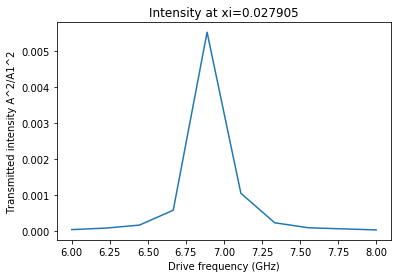

In [12]:
# Figure 2

# this needs to be like 500 or sthg, but this already takes forever
nPoints = 10
xData = np.linspace(6*GHz, 8*GHz, num = nPoints)
fig2FullYData = []

    
# drive strength: expect supersplitting when strength>1
# strengths = [0.8, 5, 20, 100]
strengths = [20]
for strength in strengths:
    xi = (1/np.sqrt(2*T1p*T2p))*strength
    fig2FullYData = []
    for i, fd in enumerate(xData):
#         if i % 10 == 0:
#             print("%d of %d done" % (i, nPoints))
        print("%d of %d done" % (i, nPoints))
        fig2FullYData.append(intensity(xi, fd*2*np.pi, EC, bestEJ))
    print("Done with strength=%.1f" % strength)
    
    plt.plot(xData, fig2FullYData)
    plt.xlabel('Drive frequency (GHz)')
    plt.ylabel('Transmitted intensity A^2/A1^2')
#     plt.ylim(0, 0.1)
    plt.title("Intensity at xi=%f" % xi)
    plt.show()

In [ ]:
plt.plot(xData, fig2FullYData)
plt.xlabel('Drive frequency (GHz)')
plt.ylabel('Transmitted intensity A^2/A1^2')
plt.title("Intensity at xi=%f" % xi)
plt.show()

# Lol idk why this plot is so weird, maybe just need more points